In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root

In [2]:
smoke_test = "CI" in os.environ
subset_starts = 420
subset_ends = 430 if smoke_test else 480
desired_frames = 500 if smoke_test else 900
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 1000
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()

In [3]:
locust_data_path = os.path.join(root, "data/foraging/locust/15EQ20191202_tracked.csv")

df = lc.load_and_clean_locust(
    path=locust_data_path,
    desired_frames=desired_frames,
    grid_size=100,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)

loc_subset = df["subset"]
loc_all = df["all_frames"]

original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 900
resulting_shape: (13500, 4)
min_time 1
max_time 900


In [33]:
object = loc_all
rewards = object.rewardsDF.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True)
df = object.foragersDF
start, end, N_obs = min(df["time"]), max(df["time"]), len(df["time"].unique())


display(df.head())

display(df["x"].describe())
print(rewards)

,x,y,time,forager,type
0,69.0,91.0,1,1,locust
1,19.0,52.0,1,2,locust
2,90.0,61.0,1,3,locust
3,51.0,97.0,1,4,locust
4,40.0,88.0,1,5,locust


count    13500.000000
mean        39.035778
std         30.385285
min          1.000000
25%         15.000000
50%         25.000000
75%         67.000000
max         99.000000
Name: x, dtype: float64

      x     y
0  84.0  48.0
1  15.0  48.0


,x,y,time,state
0,69.0,91.0,1,search_r
1,19.0,52.0,1,feed_l
2,90.0,61.0,1,search_r
3,51.0,97.0,1,edge_r
4,40.0,88.0,1,search_l


   x  y     state  time
0  0  0    edge_l     0
1  0  0    edge_r     0
2  0  0    feed_l     0
3  0  0    feed_r     0
4  0  0  search_l     0
5  0  0  search_r     0


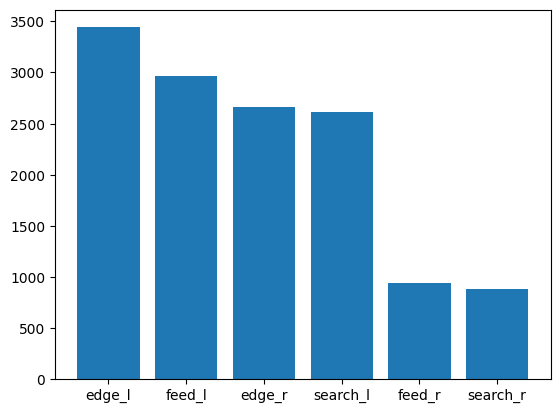

In [34]:
left_idx = rewards["x"].idxmin()
right_idx = rewards["x"].idxmax()
x_left = rewards.iloc[left_idx, 0]
y_left = rewards.iloc[left_idx, 1]

x_right = rewards.iloc[right_idx, 0]
y_right = rewards.iloc[right_idx, 1]

x_center = 50
y_center = 50


df_cat = ft.add_ring(
    df, "feed_l", x0=x_left, y0=y_left, outside_radius=10, inside_radius=0
)


df_cat = ft.add_ring(
    df_cat, "feed_r", x0=x_right, y0=y_right, outside_radius=10, inside_radius=0
)

df_cat = ft.add_ring(
    df_cat,
    "edge",
    x0=x_center,
    y0=y_center,
    outside_radius=51,
    inside_radius=47,
    divide_by_side=True,
)

df_cat = ft.add_ring(
    df_cat,
    "search",
    x0=x_center,
    y0=y_center,
    outside_radius=50,
    inside_radius=0,
    divide_by_side=True,
)


df_cat.drop(["forager", "type"], inplace=True, axis=1)

unique_states = set(df_cat["state"])


# these will be added to ensure the animation starts with
# all states represented
# ignore the initial frame in the animation
initial_fake_positions = pd.DataFrame(
    {
        "x": [0] * len(unique_states),
        "y": [0] * len(unique_states),
        "state": sorted(list(unique_states)),
        "time": [(start - 1)] * len(unique_states),
    }
)

display(df_cat.head())

print(initial_fake_positions)

plt.bar(df_cat["state"].value_counts().index, df_cat["state"].value_counts())

df_cat_vis = pd.concat([initial_fake_positions, df_cat])
object.foragersDF = df_cat_vis

In [36]:
ft.animate_foragers(
    loc_all,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    color_by_state=True,
    start_frame=start,
)

In [38]:
all_states = df_cat["state"].unique()
all_times = sorted(df_cat["time"].unique())
all_combinations = pd.DataFrame(
    [(state, time) for state in all_states for time in all_times],
    columns=["state", "time"],
)
counts = pd.merge(
    all_combinations,
    df_cat.groupby(["state", "time"]).size().reset_index(name="count"),
    how="left",
    on=["state", "time"],
)
counts["count"].fillna(0, inplace=True)

count_data = {}
for state in unique_states:
    count_data[state] = torch.tensor(counts[counts["state"] == state]["count"].values)

shapes = [tensor.shape for tensor in count_data.values()]
assert all(shape == shapes[0] for shape in shapes)


tensor_length = len(next(iter(count_data.values())))
sums_per_position = [
    sum(count_data[state][k] for state in count_data) for k in range(tensor_length)
]
assert all(
    sums_per_position[0] == sum_at_k for sum_at_k in sums_per_position[1:]
), "Population count is not constant!"

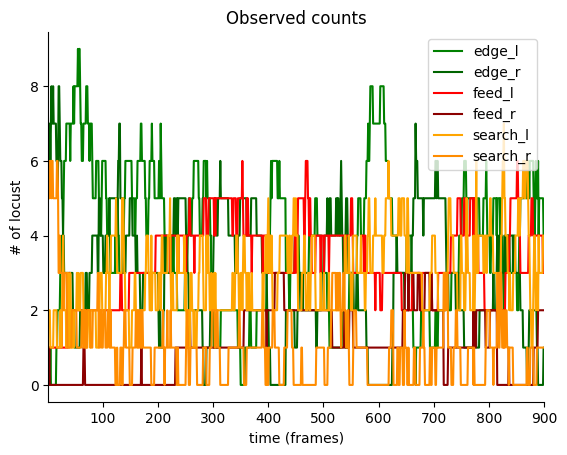

In [45]:
for state, color in zip(
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    sns.lineplot(x=all_times, y=count_data[state], label=f"{state}", color=color)

sns.despine()


plt.title("Observed counts")
plt.xlim(start, end)
plt.xlabel("time (frames)")
plt.ylabel("# of locust")
plt.legend(loc="upper right")

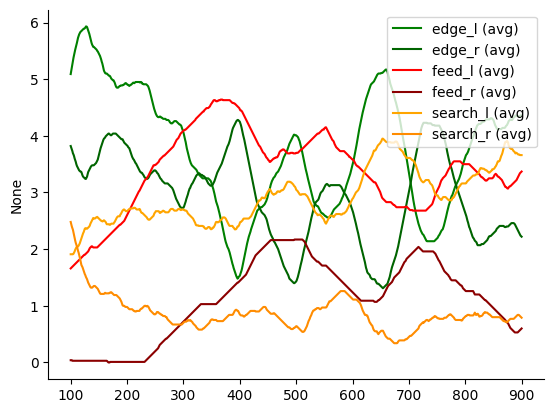

In [50]:
def moving_average(data, window_size):
    cumsum = torch.cumsum(data, dim=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1 :] / window_size


window_size = 100
running_averages = {
    state: moving_average(count_data[state].float(), window_size)
    for state in count_data
}


for state, color in zip(
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    sns.lineplot(
        x=all_times[window_size - 1 :],
        y=running_averages[state],
        label=f"{state} (avg)",
        color=color,
    )

sns.despine()